### 문제 정의

- 제주도내 주민등록인구는 2022년 기준 약 68만명으로, 연평균 1.3%정도 매년 증가하고 있습니다.

- 또한 외국인과 관광객까지 고려하면 전체 상주인구는 90만명을 넘을 것으로 추정되며, 

- 제주도민 증가와 외국인의 증가로 현재 제주도의 교통체증이 심각한 문제로 떠오르고 있습니다.

https://www.jejunews.com/news/articleView.html?idxno=2198611

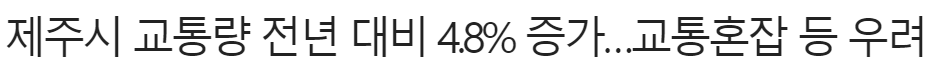

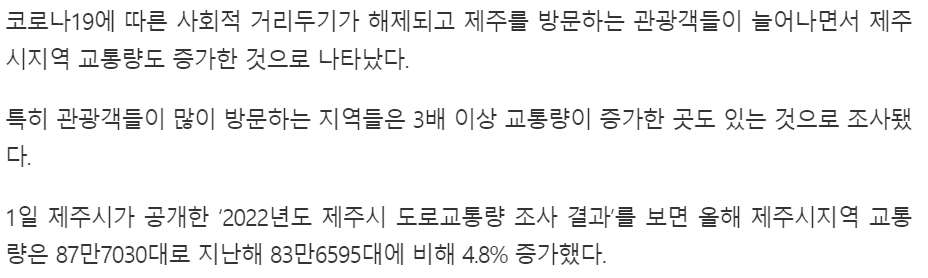

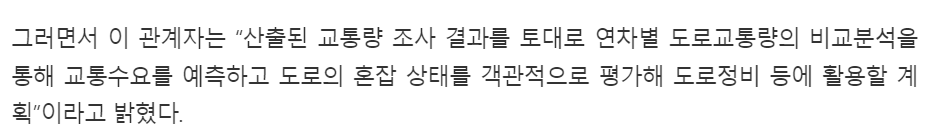

#### 라이브러리 정의

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import os

from glob import glob
from scipy import interpolate

import datetime
from datetime import timedelta
from pytz import timezone

import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error


- 용량 줄이고 빠른 작업 준비

In [2]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [3]:
csv_to_parquet('./jeju_traffic/train.csv', 'train')
csv_to_parquet('./jeju_traffic/test.csv', 'test')

train Done.
test Done.


#### 데이터 불러오기

In [4]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

In [5]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [6]:
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음


In [7]:
train.describe()

,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
count,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4701217.0,4.701217e+06,4701217.0,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06
mean,2.021672e+07,1.192820e+01,1.836651e+00,1.049585e+02,4.762597e-04,2.660218e-01,6.125329e+01,0.0,5.618742e+03,0.0,6.152237e-01,3.338432e+01,1.265217e+02,3.338432e+01,1.265217e+02,4.278844e+01
std,4.555709e+03,6.722092e+00,6.877513e-01,1.840107e+00,2.181818e-02,5.227760e+00,1.213354e+01,0.0,1.395343e+04,0.0,1.211268e+00,1.012015e-01,1.563657e-01,1.011948e-01,1.563519e-01,1.595443e+01
min,2.021090e+07,0.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,3.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.324343e+01,1.261826e+02,3.324343e+01,1.261826e+02,1.000000e+00
25%,2.021110e+07,6.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,5.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.326422e+01,1.264232e+02,3.326422e+01,1.264232e+02,3.000000e+01
50%,2.022013e+07,1.200000e+01,2.000000e+00,1.060000e+02,0.000000e+00,0.000000e+00,6.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.341257e+01,1.265112e+02,3.341257e+01,1.265112e+02,4.300000e+01
75%,2.022050e+07,1.800000e+01,2.000000e+00,1.070000e+02,0.000000e+00,0.000000e+00,7.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.347804e+01,1.265840e+02,3.347804e+01,1.265840e+02,5.400000e+01
max,2.022073e+07,2.300000e+01,3.000000e+00,1.070000e+02,1.000000e+00,1.030000e+02,8.000000e+01,0.0,5.000000e+04,0.0,3.000000e+00,3.355608e+01,1.269309e+02,3.355608e+01,1.269309e+02,1.130000e+02


### 가설 설정

In [8]:
data_info = pd.read_csv('./jeju_traffic/data_info.csv')
data_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


#### 각 칼럼 유일값 확인

day_of_week : 월~일

base_hour : 0-23

lane_count : 1,2,3

road_rating : 103(일반 국도), 106(지방도), 107(시/군도)

road_name : 61 가지의 도로명(일반국도12호선, -(결측치) 등....)

multi_linked : 0, 1

connect_code : 0, 103

maximum_speed_limit : 30, 50, 60, 70, 80

vehicle_restricted : 0

weight_restricted :0/ 43200/ 32400/ 50000

height_restricted : 0

road_type : 0, 3

start_node_name, end_node_name : 487개의 도로, 장소명

start_latitude, start_longitude : 586가지 출발점 위,경도

end_latitude, end_longitude : : 586가지 도착점 위,경도

start_turn_restricted : 있음, 없음

end_turn_restricted : 있음, 없음

target : 속도(예측해야할 값)

#### 3가지 가설

**1. 주중엔 출, 퇴근 시간대에 도로가 정체되므로 평균 속도가 상대적으로 낮을 것이다.**

**2. 차로 수가 늘어날 수록 고속도로같은 큰 도로이므로 평균 속도가 올라갈 것이다.**

**3. 제한 속도가 높을 수록 속도를 높이다가 제한 속도를 넘어버릴 수 있으므로 평균 속도가 올라갈 것이다.**

→ 이러한 경향이 2022년 8월 데이터를 예측할 때도 반영될 것이라 예상

#### 결측치 확인

In [9]:
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [10]:
test.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
dtype: int64

### EDA

#### base_date(날짜 데이터) 살펴보기

- 2022년 8월 이전 데이터

In [11]:
train['base_date'].sort_values()

430379     20210901
369019     20210901
1132647    20210901
4543127    20210901
3428956    20210901
             ...   
2053638    20220731
2748124    20220731
2447938    20220731
3749761    20220731
4680098    20220731
Name: base_date, Length: 4701217, dtype: int64

- 날짜는 2021/09/01 ~ 2022/07/31

In [12]:
train.groupby(["base_date"])["target"].size()

base_date
20210901    19722
20210902    18809
20210903    19880
20210904    17998
20210905    17836
            ...  
20220727     9195
20220728     7601
20220729     5138
20220730     1845
20220731     5539
Name: target, Length: 281, dtype: int64

In [13]:
test['base_date'].sort_values()

58553     20220801
45008     20220801
139434    20220801
186397    20220801
154249    20220801
            ...   
217025    20220831
106516    20220831
106547    20220831
281844    20220831
87204     20220831
Name: base_date, Length: 291241, dtype: int64

- 예측해야 할 데이터는 2022년 8월 1일부터 31일까지 한 달

#### 한가지 값만 가지는 칼럼 찾기

In [14]:
only_one = []
for i in train.columns[2:]:
    if len(train[i].value_counts()) < 2:
        only_one.append(i)

len(only_one)

2

In [15]:
only_one

['vehicle_restricted', 'height_restricted']

In [16]:
display(train['vehicle_restricted'].value_counts(),
        train['height_restricted'].value_counts())

0.0    4701217
Name: vehicle_restricted, dtype: int64

0.0    4701217
Name: height_restricted, dtype: int64

In [17]:
#확인된 칼럼 제거
train.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)
test.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

#### 상관관계 분석

C:\Users\Administrator\AppData\Local\Temp\ipykernel_48860\168231194.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot = True)


<Axes: >

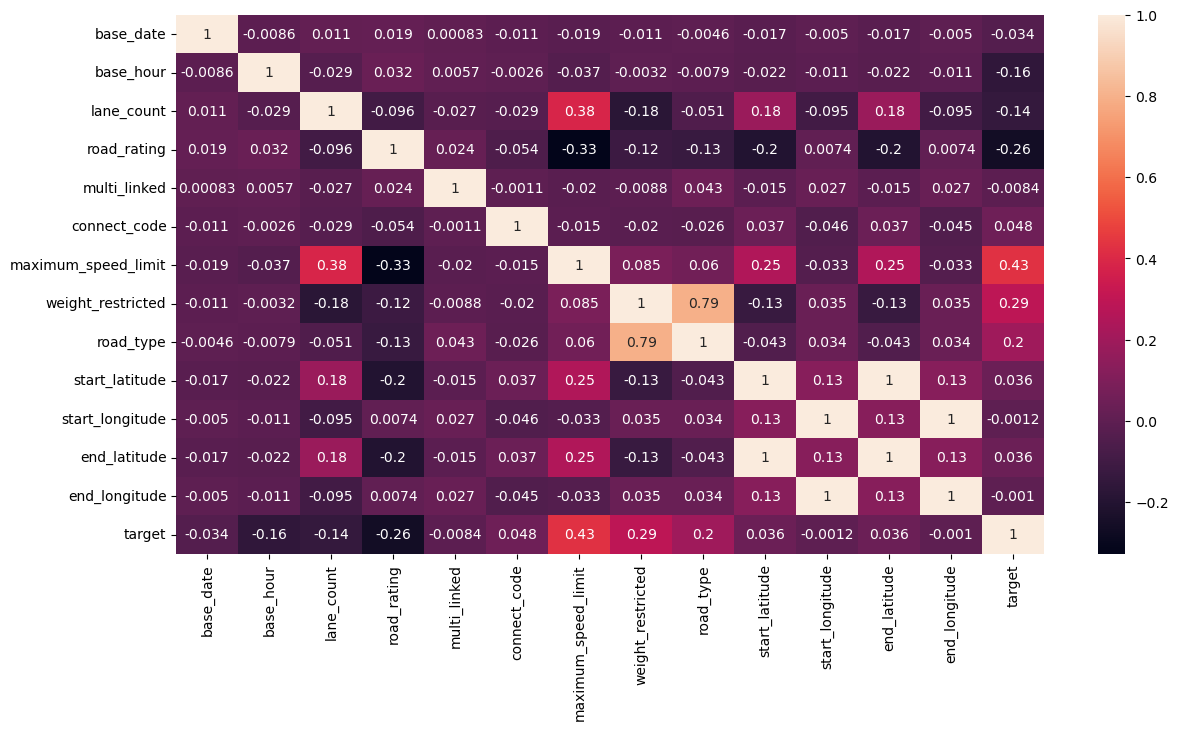

In [18]:
plt.figure(figsize = (14,7))
sns.heatmap(train.corr(), annot = True)

- 타겟값과 양의 상관관계가 높은 것은 maximum_speed_limit
    - 제한 속도가 높을 수록 평균 속도가 높아진다.
    
    
- lane_count(차로수)와 target은 음의 상관관계를 보인다.
    - 차로수가 많아질 수록 평균 속도가 낮아진다.
    
    
- weight_restricted(통과 제한 하중)은 target과의 양의 상관관계


- road_rating, road_type은 상관관계가 있으나 강하진 않음

#### 최고 제한 속도(maximum_speed_limit) 살펴보기

In [19]:
train.maximum_speed_limit.value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

<Axes: xlabel='maximum_speed_limit', ylabel='target'>

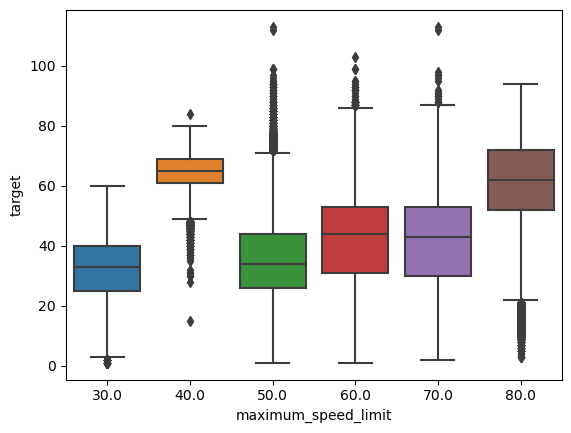

In [20]:
sns.boxplot(x = "maximum_speed_limit", y = "target", data = train)

- 제한 속도 40일 때를 제외하고 모두 평균 속도가 제한 속도 범위 내로 들어와있음

- 각 제한 속도 구간마다 값 차이가 많이 나는 이상치가 존재 >> 나중에 제거

#### 차로 수(lane_count) 살펴보기

In [21]:
train['lane_count'].value_counts()

2    2352092
1    1558531
3     790594
Name: lane_count, dtype: int64

<Axes: xlabel='target', ylabel='Count'>

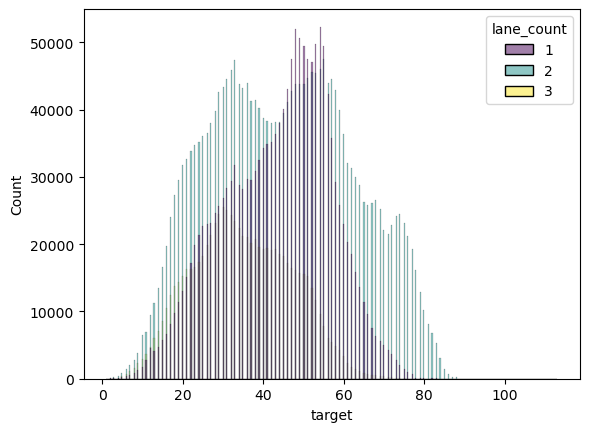

In [22]:
sns.histplot(x = train.target, 
             hue = train.lane_count,
             palette='viridis')

<Axes: xlabel='lane_count', ylabel='target'>

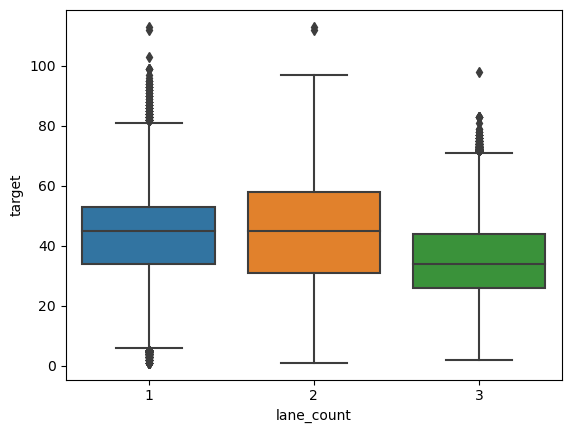

In [23]:
sns.boxplot(x = train.lane_count, y = train.target)

In [24]:
train.groupby("lane_count")["target"].mean()

lane_count
1    43.570562
2    44.915713
3    34.917783
Name: target, dtype: float64

- 차선이 늘어날 수록 평균 속도가 줄어든 모습
- 2차선일 때 가장 빠른 속도를 보임

- 3차선일 때와 1,2차선일 때가 확연히 차이를 보이므로 학습에 활용 가능

- 통과 제한 하중(weight_restricted) 살펴보기

In [25]:
train['weight_restricted'].value_counts()

0.0        4032874
43200.0     410361
32400.0     239305
50000.0      18677
Name: weight_restricted, dtype: int64

<Axes: xlabel='weight_restricted', ylabel='target'>

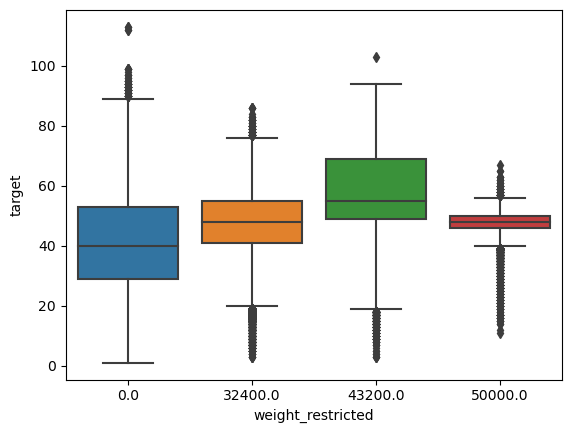

In [26]:
sns.boxplot(x='weight_restricted', y="target", data=train)

In [27]:
train.groupby("weight_restricted")["target"].mean()

weight_restricted
0.0        40.955696
32400.0    47.453350
43200.0    57.883888
50000.0    47.088665
Name: target, dtype: float64

<Axes: xlabel='weight_restricted', ylabel='target'>

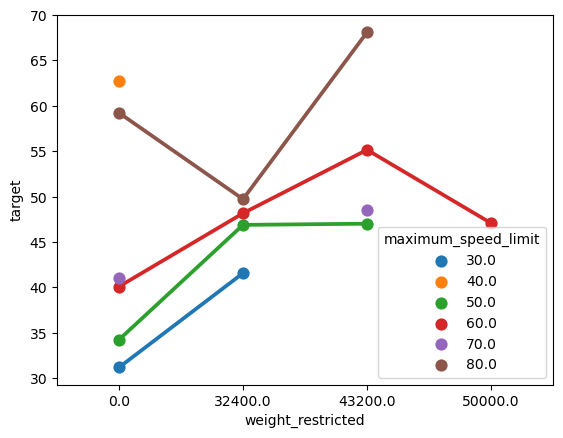

In [28]:
#통과제한하중에 따른 평균 속도를 제한 속도별로 나눠서 시각화

sns.pointplot(data = train, x = "weight_restricted",
              y = "target", 
              hue= "maximum_speed_limit")

- 제한 하중이 없을 때 평균 속도가 낮게 나옴

#### 도로 등급(road_rating) 살펴보기

In [29]:
train.loc[train['road_rating'] == 0, 'road_rating'] = 103
train.loc[train['road_rating'] == 2, 'road_rating'] = 107
train.loc[train['road_rating'] == 1, 'road_rating'] = 106

In [30]:
train['road_rating'].value_counts()

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64

In [31]:
test.loc[test['road_rating'] == 0, 'road_rating'] = 103
test.loc[test['road_rating'] == 2, 'road_rating'] = 107
test.loc[test['road_rating'] == 1, 'road_rating'] = 106

In [32]:
test['road_rating'].value_counts()

107    129304
103    116305
106     45632
Name: road_rating, dtype: int64

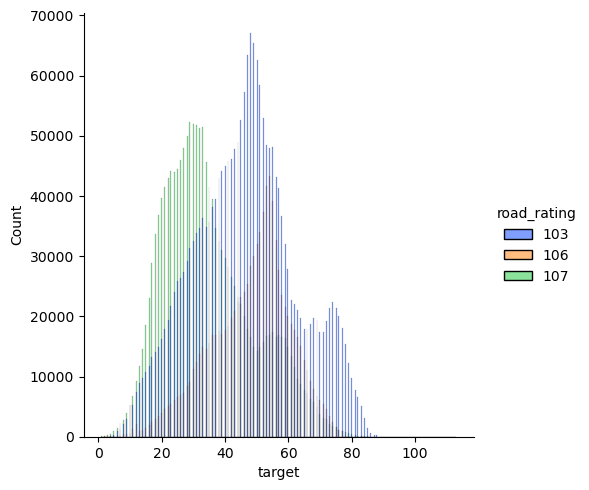

In [33]:
sns.displot(x = train.target, 
            hue = train.road_rating,
            palette="bright")

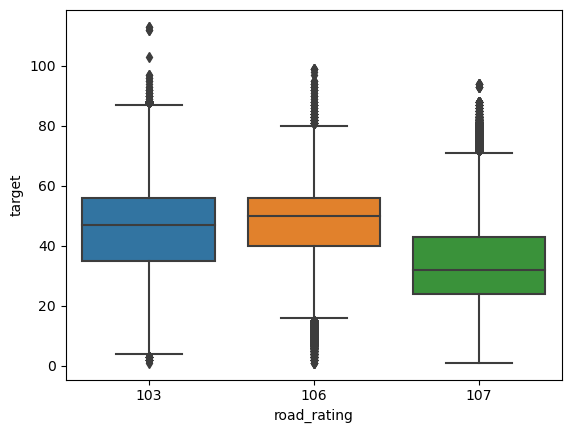

In [34]:
fig = sns.boxplot(x='road_rating', y="target", data=train)

In [35]:
print(train.groupby("road_rating")["target"].mean())
print(train.groupby("road_rating")["target"].max())

road_rating
103    46.388468
106    48.021548
107    34.701408
Name: target, dtype: float64
road_rating
103    113.0
106     99.0
107     94.0
Name: target, dtype: float64


- 도로등급이 106, 103일 때 높은 속도를 보임

- max값에서도 107이 가장 낮은 속도를 보임

#### 도로 유형(road_type) 살펴보기

In [36]:
train['road_type'].value_counts()

0    3737117
3     964100
Name: road_type, dtype: int64

road_type
0    Axes(0.125,0.11;0.775x0.77)
3    Axes(0.125,0.11;0.775x0.77)
Name: target, dtype: object

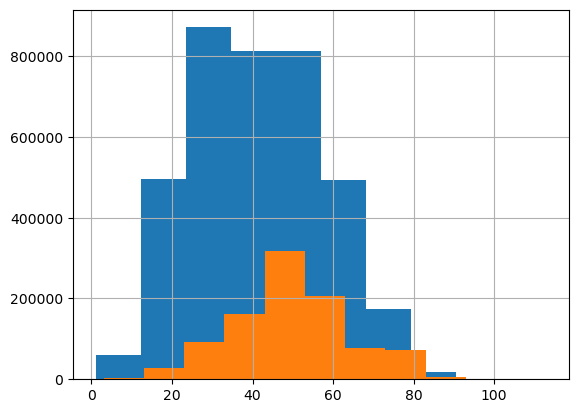

In [37]:
train.groupby("road_type")["target"].hist()

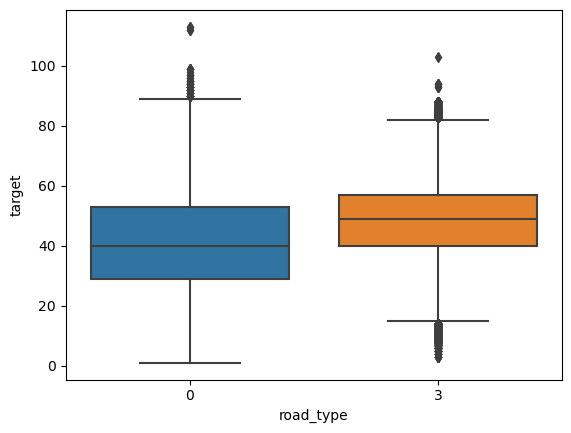

In [38]:
fig = sns.boxplot(x='road_type', y="target", data=train)

In [39]:
print(train.groupby("road_type")["target"].mean())
print(train.groupby("road_type")["target"].max())
print(train.groupby("road_type")["target"].std())

road_type
0    41.160930
3    49.097125
Name: target, dtype: float64
road_type
0    113.0
3    103.0
Name: target, dtype: float64
road_type
0    15.949523
3    14.320773
Name: target, dtype: float64


- 평균에 그렇게 큰 차이가 나지는 않는다

#### 중용구간 여부(multi_linked) 살펴보기

- 중용구간이란?

    - 2개 이상의 노선이 도로 일정 구간을 공동으로 사용하는 구간

In [40]:
train['multi_linked'].value_counts()

0    4698978
1       2239
Name: multi_linked, dtype: int64

multi_linked
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: target, dtype: object

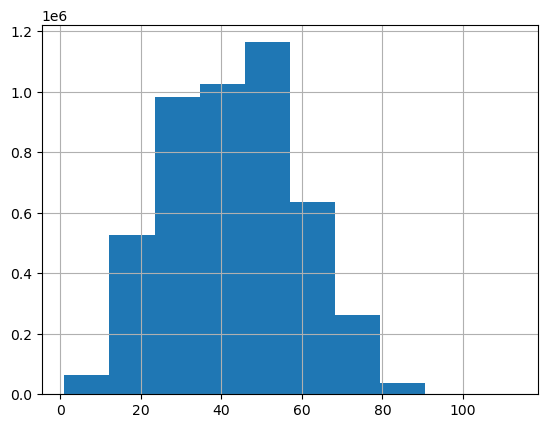

In [41]:
train.groupby("multi_linked")["target"].hist()

In [42]:
print(train.groupby("multi_linked")["target"].mean())
print(train.groupby("multi_linked")["target"].std())

multi_linked
0    42.791370
1    36.642698
Name: target, dtype: float64
multi_linked
0    15.954885
1    13.661950
Name: target, dtype: float64


<Axes: xlabel='multi_linked', ylabel='target'>

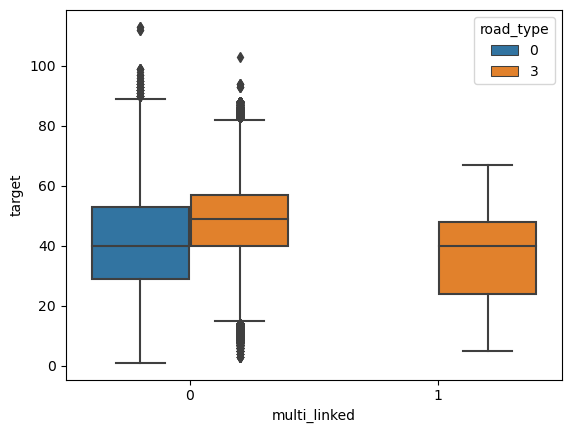

In [43]:
# 평균에 큰 차이가 나지 않았던 road_type별로 상자그림

sns.boxplot(x = "multi_linked",
            y = "target", data = train,
            hue = "road_type")

- 도로유형이 0이면서 중용구간이 1인 값이 없음

- 중용구간인 구간이 거의 없어서.. mulit_linked 칼럼은 road_type보다 값이 적으므로 이걸 제거하는 것이 나아보임

#### 연결로 코드(connect_code) 살펴보기

- 연결로란?
    - 입체로 교차하는 도로에서 서로 교차하는 도로를 연결하거나 높이 차이가 있는 도로를 연결하는 도로

In [44]:
train['connect_code'].value_counts()

0      4689075
103      12142
Name: connect_code, dtype: int64

- 연결로가 103인 데이터가 너무 적음

connect_code
0      Axes(0.125,0.11;0.775x0.77)
103    Axes(0.125,0.11;0.775x0.77)
Name: target, dtype: object

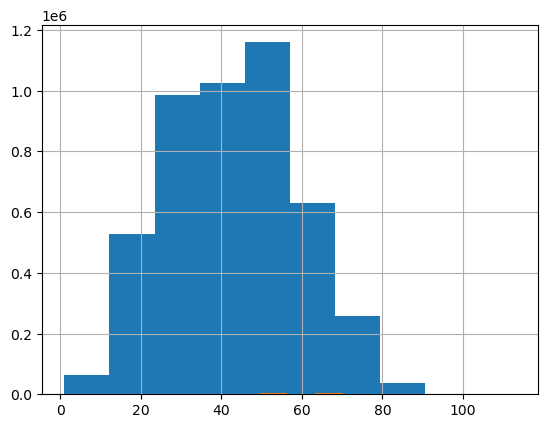

In [45]:
train.groupby(["connect_code"])["target"].hist()

In [46]:
print(train.groupby("connect_code")["target"].mean())
print(train.groupby("connect_code")["target"].std())

connect_code
0      42.749190
103    57.947043
Name: target, dtype: float64
connect_code
0      15.949711
103     9.075532
Name: target, dtype: float64


- 연결로 코드가 103인 곳에서 빠른 평균 속도를 보임

#### 시간(base_hour) 살펴보기

In [47]:
train.groupby("base_hour")["target"].count().sort_values(ascending = True)

base_hour
0     154158
3     155938
4     165284
2     169322
5     181128
1     182353
23    184229
6     189418
7     199061
22    200629
8     201875
21    203585
20    205059
9     205327
10    206316
18    207500
17    208377
16    208420
11    208515
19    209870
12    211833
14    214182
13    214297
15    214541
Name: target, dtype: int64

In [48]:
train.groupby("base_hour")["target"].value_counts(ascending = False)

base_hour  target
0          52.0      4546
           51.0      4545
           50.0      4529
           54.0      4311
           49.0      4149
                     ... 
23         87.0        11
           2.0          9
           88.0         5
           92.0         2
           1.0          1
Name: target, Length: 2100, dtype: int64

In [49]:
#0시부터 23시까지 평균속도 구하는 for문
for i in range(24):
    mean_time = train[train["base_hour"] == i]["target"].mean()
    print("{}시의 평균 속도: {} km". format(i, mean_time))

0시의 평균 속도: 48.74219956148886 km
1시의 평균 속도: 49.76329975377427 km
2시의 평균 속도: 50.27865841414583 km
3시의 평균 속도: 50.54325437032667 km
4시의 평균 속도: 49.747525471309984 km
5시의 평균 속도: 47.20113952563933 km
6시의 평균 속도: 45.549029131339154 km
7시의 평균 속도: 43.682268249431075 km
8시의 평균 속도: 41.65629226006192 km
9시의 평균 속도: 40.87593935527232 km
10시의 평균 속도: 40.22223191608988 km
11시의 평균 속도: 39.82459295494329 km
12시의 평균 속도: 39.83853790485902 km
13시의 평균 속도: 39.73147080920405 km
14시의 평균 속도: 39.561120915856606 km
15시의 평균 속도: 39.35169967512037 km
16시의 평균 속도: 39.127929181460516 km
17시의 평균 속도: 38.47336318307683 km
18시의 평균 속도: 38.2412578313253 km
19시의 평균 속도: 40.10411206937628 km
20시의 평균 속도: 41.11380627039048 km
21시의 평균 속도: 42.17343124493455 km
22시의 평균 속도: 43.989861884373646 km
23시의 평균 속도: 45.807739281003535 km


In [50]:
train.groupby("base_hour")["target"].mean().sort_values(ascending = False)

base_hour
3     50.543254
2     50.278658
1     49.763300
4     49.747525
0     48.742200
5     47.201140
23    45.807739
6     45.549029
22    43.989862
7     43.682268
21    42.173431
8     41.656292
20    41.113806
9     40.875939
10    40.222232
19    40.104112
12    39.838538
11    39.824593
13    39.731471
14    39.561121
15    39.351700
16    39.127929
17    38.473363
18    38.241258
Name: target, dtype: float64

<Axes: ylabel='target'>

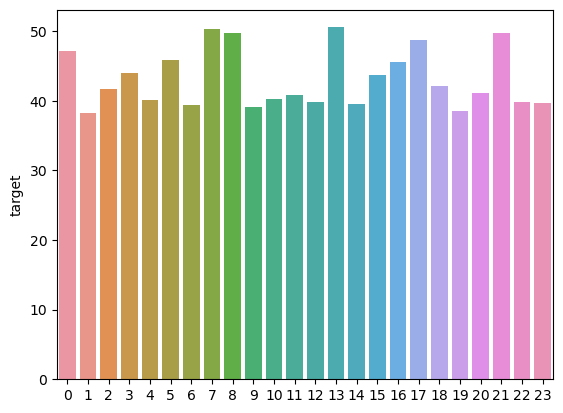

In [51]:
sns.barplot(x = train.base_hour.unique(), y = train.groupby("base_hour")["target"].mean())

<Axes: xlabel='base_hour', ylabel='target'>

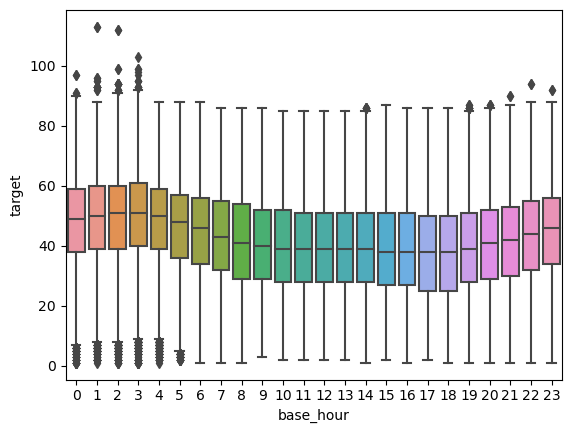

In [52]:
sns.boxplot(x = train.base_hour, y = train.target)

#### 타겟값 '속도' 살펴보기

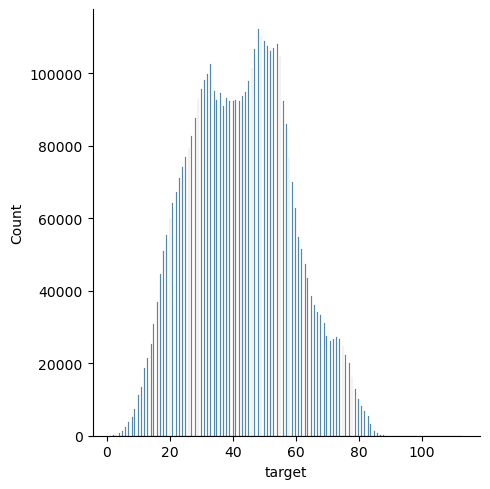

In [53]:
sns.displot(train.target)

- 정규분포의 모습
- 첨도는 어느정도 있고 왜도는 거의 없음 >> 로그 변환 불필요

### 전처리

#### 날짜 데이터 정제 과정: base_date 칼럼

In [54]:
EVAL = False

In [55]:
if EVAL:
    train['base_date'] = train['base_date'].astype('str') 
    train['year'] = train['base_date'].apply(lambda x: x[:4]).astype('int')    
    train['month'] = train['base_date'].apply(lambda x: x[4:6]).astype('int')
    train['day'] = train['base_date'].apply(lambda x: x[6:8]).astype('int')   
    
    test = train.query('month==7 and year==2022 and day>15').reset_index(drop=True)
    train = train.query('month!=7 or year!=2022 or day<=15').reset_index(drop=True)
    
    train.shape, test.shape
else:
    train['base_date'] = train['base_date'].astype('str')     
    train['year'] = train['base_date'].apply(lambda x: x[:4]).astype('int')    
    train['month'] = train['base_date'].apply(lambda x: x[4:6]).astype('int')    
    train['day'] = train['base_date'].apply(lambda x: x[6:8]).astype('int')
    
    train.shape, test.shape

#### 라벨 인코딩: object형 변수 변환

In [56]:
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted',
           'road_name','road_type','road_rating','start_node_name','end_node_name',
           'start_latitude','end_latitude','start_longitude','end_longitude']

for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              object 
 2   day_of_week            int32  
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              int32  
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  weight_restricted      float64
 11  road_type              int64  
 12  start_node_name        int32  
 13  start_latitude         int64  
 14  start_longitude        int64  
 15  start_turn_restricted  int32  
 16  end_node_name          int32  
 17  end_latitude           int64  
 18  end_longitude          int64  
 19  end_turn_restricted    int32  
 20  target                 float64
 21  year                   int32  
 22  month             

#### 